# EDA Notebook

In [1]:
# Importing Necessary Packages
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk import FreqDist, bigrams
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from sklearn.feature_extraction.text import CountVectorizer
from string import punctuation
import re
import pickle
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from os.path import exists

# Importing Custom functions from code folder
import sys  
sys.path.insert(0, './code/')
import contraction
import data_preparation as dp
import visualizations as viz

# Setting Default Params for Visualizations
params = {'axes.titlesize': 20,
          'axes.labelsize' : 16,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'font.size': 14,
          'figure.figsize': (12, 8)}
plt.rcParams.update(params)
plt.style.use('seaborn-darkgrid')

## Cleaning Data

The title, article text, and labels from [these] dataset were collected and turned into a compressed csv file. To see the process used to collect and merge the data, consult the readme in the data folder.

In [2]:
data = pd.read_csv('./data/complete_data.zip')
data.head()

,title,text,label
0,Virginia Republican Wants Schools To Check Chi...,Sponsored Links\n\nRepublican attacks on trans...,fake
1,Mental Images,Mental Images\n\n“My pictures ask where does t...,fake
2,Denzel Washington hit by Facebook fake news st...,But it appears not all Mr Zuckerberg's own emp...,fake
3,Song Lyrics & Knowledge,Genius Nickname\n\nEmail\n\nPassword\n\nBy cli...,fake
4,Thinking about writing in a candidate on Elect...,Getting ballot access can be hard for smaller ...,fake


The raw data consists of 67207 articles.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67207 entries, 0 to 67206
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   67207 non-null  object
 1   text    67207 non-null  object
 2   label   67207 non-null  object
dtypes: object(3)
memory usage: 1.5+ MB


The maximum article length is 18004 and shortest is 0.

In [4]:
data['totalwords'] = data['text'].str.split().str.len()

In [5]:
data['totalwords'].max()

18004

In [6]:
data['totalwords'].min()

0

We can see that the data is mostly short with long tails of a few much longer articles.

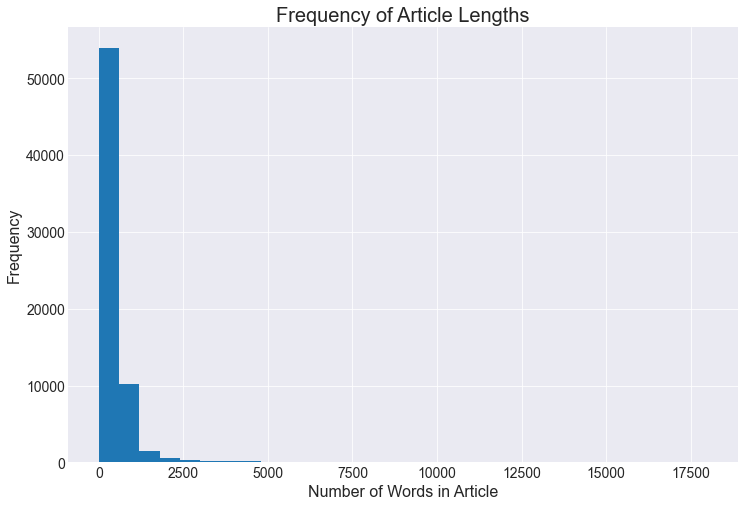

In [7]:
data['totalwords'].hist(bins=30)
plt.xlabel('Number of Words in Article')
plt.ylabel('Frequency')
plt.title('Frequency of Article Lengths');

Taking a closer look we can see that there is a cluster of shorter articles.

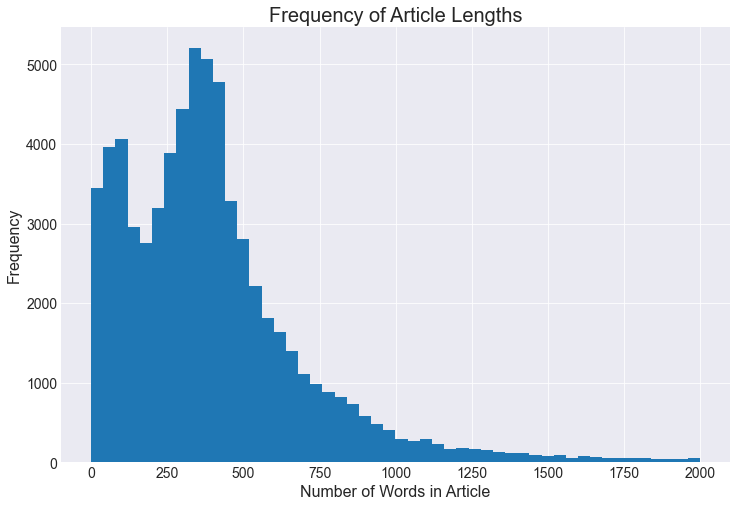

In [8]:
data[data['totalwords'] < 2000]['totalwords'].hist(bins=50)
plt.xlabel('Number of Words in Article')
plt.ylabel('Frequency')
plt.title('Frequency of Article Lengths');

We can see that there is some bias in the data towards shorter real articles. and some bias in the fake news data to extremely short articles.

In [9]:
real = data[data['label']=='real']
fake = data[data['label']=='fake']

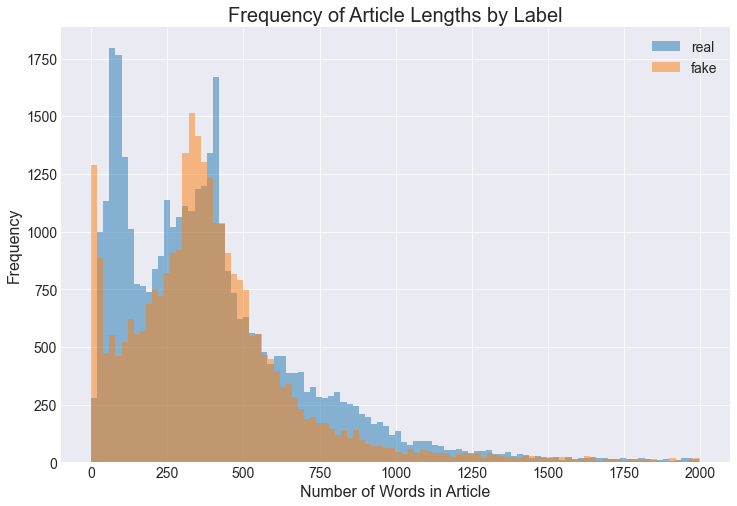

In [10]:
plt.hist(real[real['totalwords'] < 2000]['totalwords'], bins=100, alpha=0.5, label="real")
plt.hist(fake[fake['totalwords'] < 2000]['totalwords'], bins=100, alpha=0.5, label="fake")
plt.xlabel('Number of Words in Article')
plt.ylabel('Frequency')
plt.legend()
plt.title('Frequency of Article Lengths by Label');

There are 631 articles with titles but no text body. Some are likely due articles that just display pictures or videos being included in the data set.

In [11]:
data[data['totalwords'] ==0]

,title,text,label,totalwords
31182,TAKE OUR POLL: Who Do You Think President Trum...,,fake,0
31300,Joe Scarborough BERATES Mika Brzezinski Over “...,,fake,0
31449,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,fake,0
31484,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,fake,0
31495,SHOCKER: Public School Turns Computer Lab Into...,,fake,0
...,...,...,...,...
42085,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,fake,0
42086,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,fake,0
42116,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,fake,0
42132,(VIDEO) HYSTERICAL SNL TAKE ON HILLARY’S ANNOU...,,fake,0


We will drop the values with less than 10 words, since we intend to test a build of a text based rather than multimedia classifier.

In [12]:
data.drop(data[data.totalwords < 10].index, inplace=True)
data['totalwords'].min()

10

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66228 entries, 0 to 67206
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       66228 non-null  object
 1   text        66228 non-null  object
 2   label       66228 non-null  object
 3   totalwords  66228 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 2.5+ MB


To clean the data we will remove tabs, line breaks, special characters.
We will remove the (Reuters) tag from articles to avoid overfitting on the existence of this tag in recognizing reliable articles.
We will replace any URLs with the word url to minimize total unique words.
We will expand contractions to reduce the number of words as well as lowercase the text.

In [14]:
def clean(article):
    
    # Removing Reuter's tag that will bias data
    # However, there maybe be some bias remaining due to formating, but we probably want that
    # We are only removing parentethical because other articles or text might reference reuters
    # and that is likely to be useful indicator
    article=article.replace('(Reuters)','')
    article=article.replace('(reuters)','')
    
    # Replacing newline and tabs with space
    article=article.replace('\n',' ')
    article=article.replace('\t',' ')
            
    # Remove Special characters
    article = re.sub(r"\x89Û_", "", article)
    article = re.sub(r"\x89ÛÒ", "", article)
    article = re.sub(r"\x89ÛÓ", "", article)
    article = re.sub(r"\x89ÛÏ", "", article)
    article = re.sub(r"\x89Û÷", "", article)
    article = re.sub(r"\x89Ûª", "", article)
    article = re.sub(r"\x89Û\x9d", "", article)
    article = re.sub(r"\x89Û¢", "", article)
    article = re.sub(r"\x89Û¢åÊ", "", article)
    article = re.sub(r"&quot;", "", article)
        
    # Replacing URLs with url
    article = re.sub(r'http\S+', "url", article)  
    
    # Expand Contractions
    article = contraction.expand_contractions(article)
    
    # Remove Punctuation
    article = re.sub(r'[^\w\s]', ' ', article)
    
    # Lowercase for reduced Dimensionality
    article = article.lower()
    
    # Replace any created doublespaces
    article = re.sub("\s\s+", " ", article)
    
    return article

In [15]:
example = "(Reuters) https://nlp.stanford.edu/projects/glove/ and some other words (don't you know)."

In [16]:
clean(example)

' url and some other words do not you know '

In [17]:
# Step takes significant time if clean data pickle doesn't exist
if not exists('data/clean_data.pickle'):
    data['cleaned_text'] = data['text'].apply(clean)
    data['cleaned_title'] = data['title'].apply(clean)

We will likely leave stop word in during the final model construction, since many stop words have significant effects on meaning, but for the purpose of making visualizations, we will also create a column with the stopwords removed.

In [18]:
def remove_stopwords(article):
    """
    Given an string, returns a string with stop words removed
    """
    cached_stop_words = stopwords.words('english')
    return ' '.join([word for word in article.split() if word not in cached_stop_words])

In [19]:
# Step takes significant time if clean data pickle doesn't exist
if not exists('data/clean_data.pickle'):
    data['no_stop_text'] = data['cleaned_text'].apply(remove_stopwords)

In [20]:
data.drop(columns=['title', 'text', 'totalwords'], inplace=True)

In [21]:
if not exists('data/clean_data.pickle'):
    with open('data/clean_data.pickle', 'wb') as f:
        pickle.dump(data, f)

In [22]:
with open('data/clean_data.pickle', 'rb') as file:
    data = pickle.load(file)

In [23]:
data.head()

,label,cleaned_text,cleaned_title,no_stop_text
0,fake,sponsored links republican attacks on transgen...,virginia republican wants schools to check chi...,sponsored links republican attacks transgender...
1,fake,mental images my pictures ask where does the t...,mental images,mental images pictures ask truth end lies begi...
2,fake,but it appears not all mr zuckerbergs own empl...,denzel washington hit by facebook fake news st...,appears mr zuckerbergs employees satisfied res...
3,fake,genius nickname email password by clicking cre...,song lyrics knowledge,genius nickname email password clicking create...
4,fake,getting ballot access can be hard for smaller ...,thinking about writing in a candidate on elect...,getting ballot access hard smaller campaigns f...


## Constructing Visuals

We will word tokinize the text to aid in visualization.

In [24]:
data['tokened_text'] = data['no_stop_text'].apply(word_tokenize)

### Most Common Words

We can see some interesting features of the data just from the most frequent words. Clearly there are many articles quoting people, hence the presence of "said" and many articles about Trump as to be expected given that much of the data is from the time he was still in office.

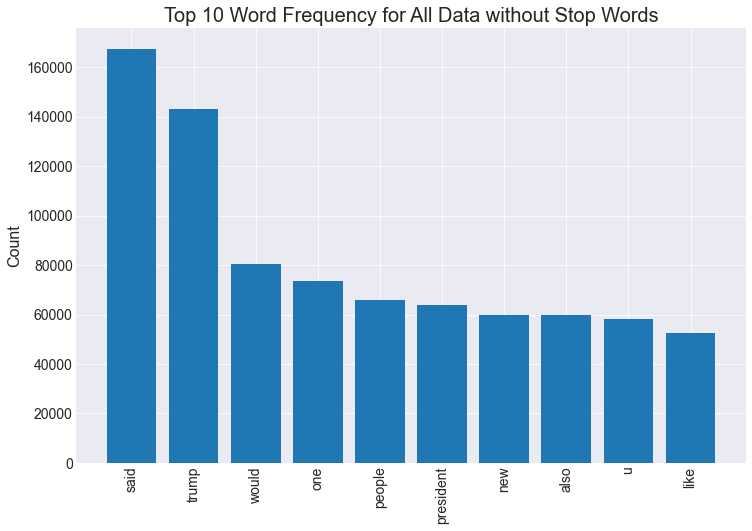

In [30]:
total_freq_dist = FreqDist(data['tokened_text'].explode())
viz.visualize_top_10(total_freq_dist,
                     "Top 10 Word Frequency for All Data without Stop Words",
                     save_name='EDA/single_freq_all');

The real news data seems similar to the overall data, with a bit less mention of Trump.

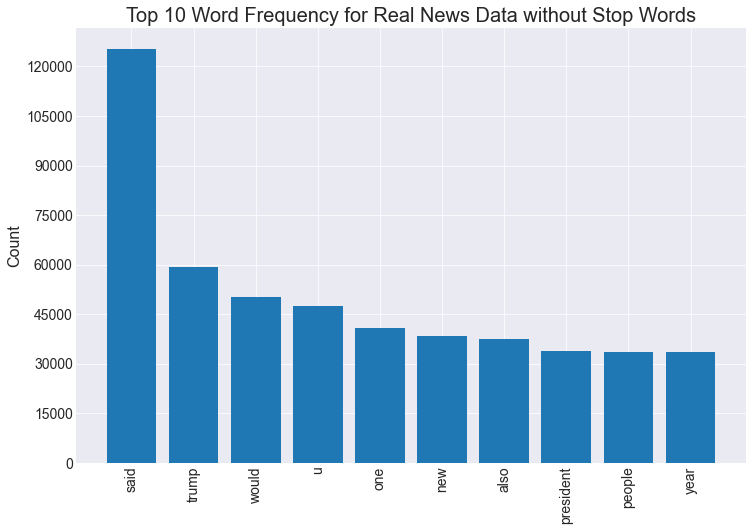

In [31]:
real = data[data['label']=='real']
real_explode = real['tokened_text'].explode()
real_freq_dist = FreqDist(real_explode)
viz.visualize_top_10(real_freq_dist,
                     "Top 10 Word Frequency for Real News Data without Stop Words",
                     save_name='EDA/single_freq_real');

The fake news data is very Trump heavy and also sees Clinton enter into the top 10.

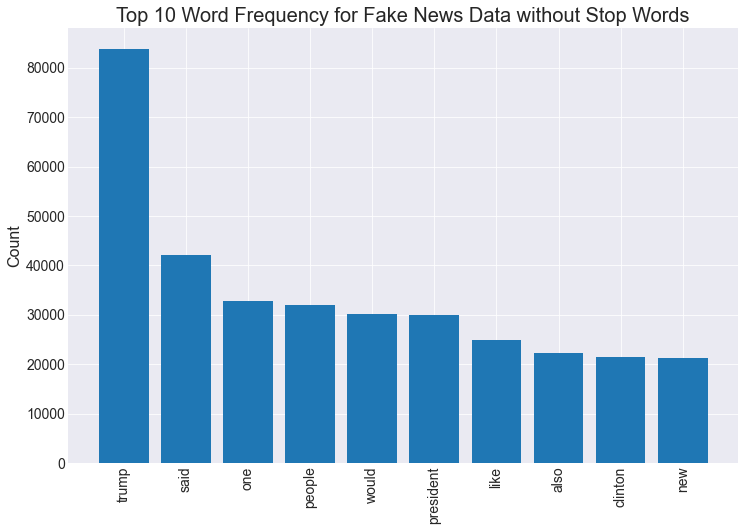

In [32]:
fake = data[data['label']=='fake']
fake_explode = fake['tokened_text'].explode()
fake_freq_dist = FreqDist(fake_explode)
viz.visualize_top_10(fake_freq_dist,
                     "Top 10 Word Frequency for Fake News Data without Stop Words",
                     save_name='EDA/single_freq_fake');

### Word Clouds of Word Frequency

Let's get a better overall feel for the frequencies using some word clouds.

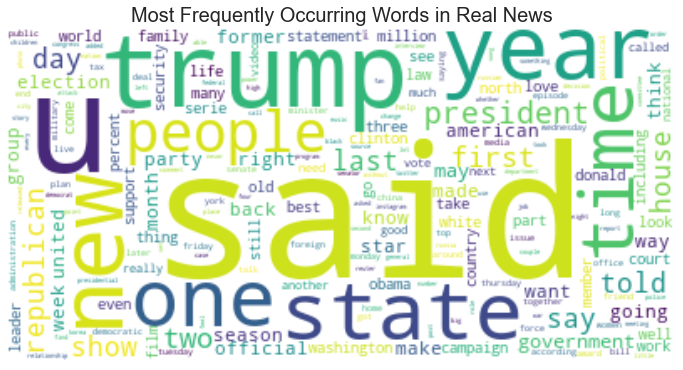

In [33]:
real_text = " ".join(article for article in real['no_stop_text'])
real_cloud = WordCloud(collocations = False, background_color = 'white').generate(real_text)
plt.imshow(real_cloud, interpolation='bilinear')
plt.title('Most Frequently Occurring Words in Real News')
plt.axis("off")
plt.savefig(f'images/EDA/single_freq_real_cloud.png')
plt.show()

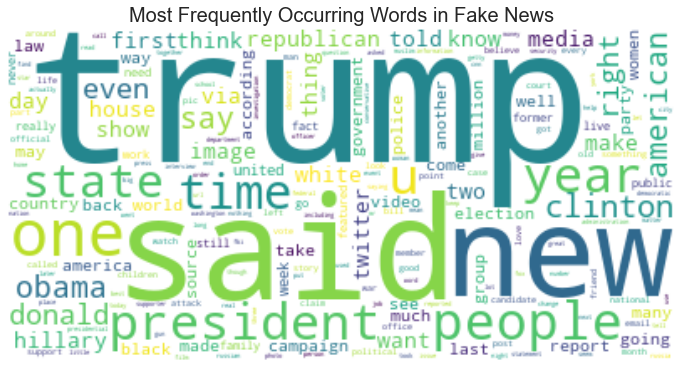

In [34]:
fake_text = " ".join(article for article in fake['no_stop_text'])
fake_cloud = WordCloud(collocations = False, background_color = 'white').generate(fake_text)
plt.imshow(fake_cloud, interpolation='bilinear')
plt.title('Most Frequently Occurring Words in Fake News')
plt.axis("off")
plt.savefig(f'images/EDA/single_freq_fake_cloud.png')
plt.show()

## Bigrams

It is often easier to see the differences in data by looking at the frequency of bigrams rather than single words.

In [35]:
real_bigram_measures = BigramAssocMeasures()
real_finder = BigramCollocationFinder.from_words(real_explode)
real_scored = real_finder.score_ngrams(real_bigram_measures.raw_freq)
fake_bigram_measures = BigramAssocMeasures()
fake_finder = BigramCollocationFinder.from_words(fake_explode)
fake_scored = fake_finder.score_ngrams(fake_bigram_measures.raw_freq)

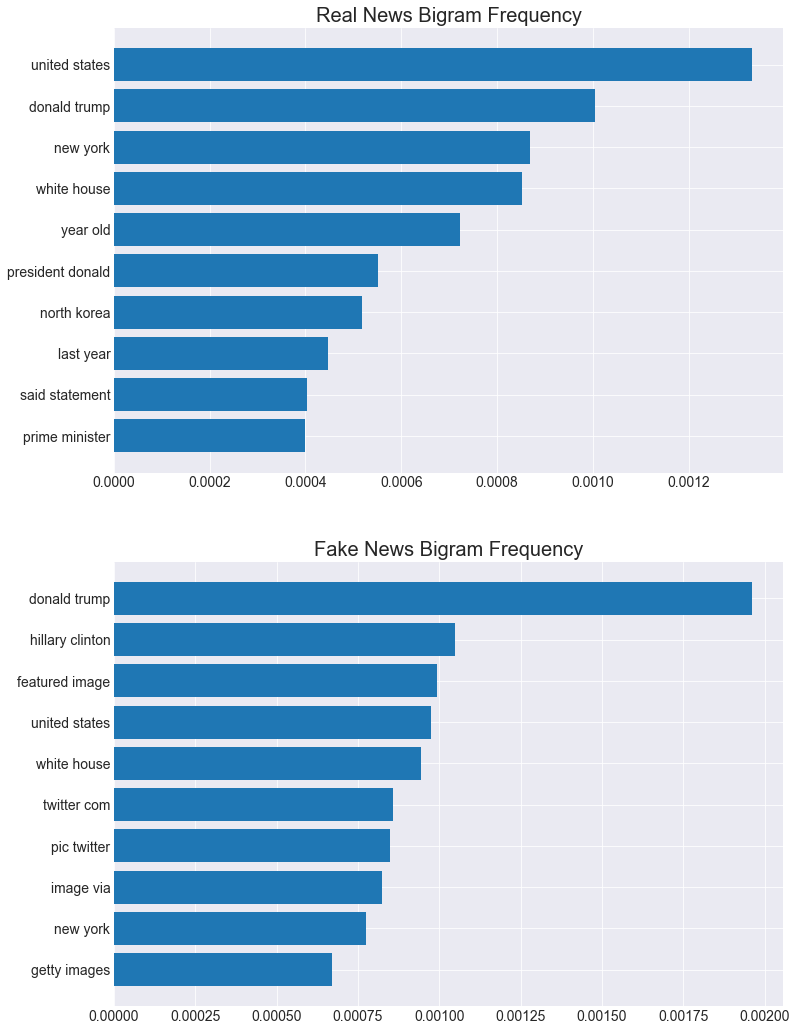

In [36]:
real_x = [' '.join(t[0]) for t in real_scored[:10]]
real_x.reverse()
real_y = [t[1] for t in real_scored[:10]]
real_y.reverse()
fake_x = [' '.join(t[0]) for t in fake_scored[:10]]
fake_x.reverse()
fake_y = [t[1] for t in fake_scored[:10]]
fake_y.reverse()
plt.figure(figsize = (12,18)) 
plt.subplot(2,1,1)
plt.barh(real_x, real_y)
plt.title('Real News Bigram Frequency')
plt.subplot(2,1,2)
plt.barh(fake_x, fake_y)
plt.title('Fake News Bigram Frequency')
plt.savefig(f'images/EDA/bigram_freq_real.png')
plt.show();

Beyond the appearence of Clinton in the data, we see twitter mentions and mentions of images much more frequently in the fake news data.

### Bigram Word Clouds

In [37]:
# Constructing a list of joined bigrams
real_bigrams = [' '.join(tup[0]) for tup in real_scored]
# Getting Frequencies for each joined bigram
real_bigram_freq = [t[1] for t in real_scored]
# Making Dictionary
real_dictionary = dict(zip(real_bigrams, real_bigram_freq))

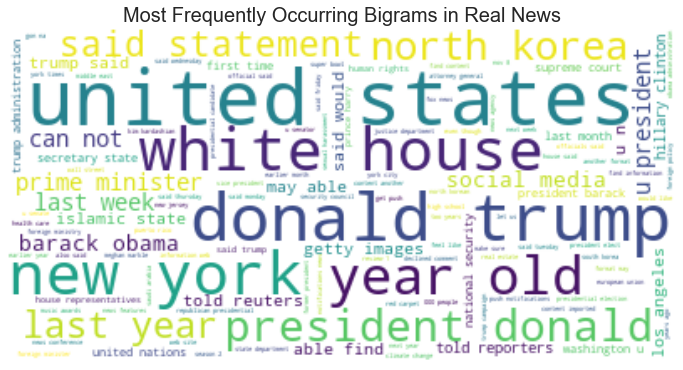

In [38]:
real_bi_cloud = WordCloud(background_color = 'white')
real_bi_cloud.generate_from_frequencies(real_dictionary)
plt.title('Most Frequently Occurring Bigrams in Real News')
plt.imshow(real_bi_cloud, interpolation='bilinear')
plt.axis("off")
plt.savefig(f'images/EDA/bigram_freq_real_cloud.png')
plt.show()

In [39]:
# Constructing a list of joined bigrams
fake_bigrams = [' '.join(tup[0]) for tup in fake_scored]
# Getting Frequencies for each joined bigram
fake_bigram_freq = [t[1] for t in fake_scored]
# Making Dictionary
fake_dictionary = dict(zip(fake_bigrams, fake_bigram_freq))

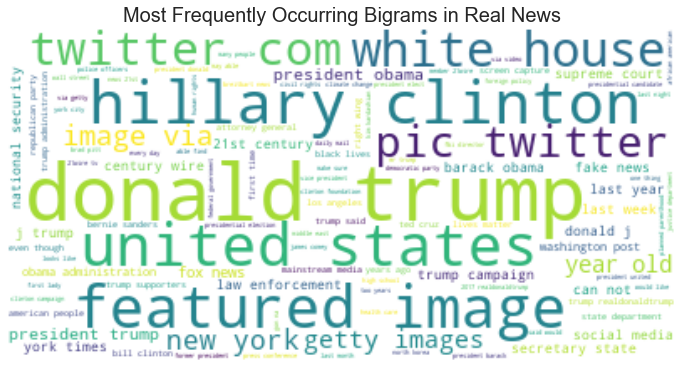

In [40]:
fake_bi_cloud = WordCloud(background_color = 'white')
fake_bi_cloud.generate_from_frequencies(fake_dictionary)
plt.title('Most Frequently Occurring Bigrams in Real News')
plt.imshow(fake_bi_cloud, interpolation='bilinear')
plt.axis("off")
plt.savefig(f'images/EDA/bigram_freq_fake_cloud.png')
plt.show()

The bigrams are significantly different, which suggests that the model will likely have significant differences between the real and fake categories to use in prediction.